<a href="https://colab.research.google.com/github/subhrajit77/Palm-Plant-Disease-detection-using-ML-DL/blob/main/Copy_of_palm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/WSD Dataset/"
SAVE_IMG_PATH = "/content/drive/MyDrive/WSD_Preprocessed"  # For PNG
SAVE_ARRAY_PATH = "/content/drive/MyDrive/WSD_Dataset_Preprocessed.npz"  # For NumPy arrays
CATEGORIES = ["healthy", "white scale/Stage1", "white scale/Stage2", "white scale/Stage3"]
IMG_SIZE = 224

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


Data Preprocessing

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

def preprocess_image(img_path, img_size=224):
    """Load an image, apply zero-padding to maintain aspect ratio, resize to 224x224, and normalize."""
    img = cv2.imread(img_path)
    h, w, c = img.shape  # Get original dimensions

    # Create a square black background
    max_dim = max(h, w)
    padded_img = np.zeros((max_dim, max_dim, c), dtype=np.uint8)

    # Centering the original image in the padded square
    x_offset = (max_dim - w) // 2
    y_offset = (max_dim - h) // 2
    padded_img[y_offset:y_offset + h, x_offset:x_offset + w] = img

    # Resize to 224x224 for VGG16
    resized_img = cv2.resize(padded_img, (img_size, img_size))
    resized_img = resized_img / 255.0  # Normalize pixel values (0-1)
    return resized_img

def load_images(data_dir, categories, img_size=224):
    """Load images from dataset folders, preprocess them, and return NumPy arrays."""
    data = []
    labels = []

    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)  # Assigned numeric labels (0,1,2,3)

        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            try:
                processed_img = preprocess_image(img_path, img_size)
                data.append(processed_img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image: {img_path}")

    return np.array(data), np.array(labels)


DATASET_PATH = "/content/drive/MyDrive/WSD Dataset"
X, y = load_images(DATASET_PATH, CATEGORIES, IMG_SIZE)

# Verified dataset shape
print(f"Dataset size: {len(X)}, Image shape: {X.shape}, Labels: {len(y)}")


Dataset size: 2161, Image shape: (2161, 224, 224, 3), Labels: 2161


Dataset Split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)} images")
print(f"Testing set size: {len(X_test)} images")


Training set size: 1728 images
Testing set size: 433 images


#Data Augmentation

In [ ]:
# Applied augmentation only to training data
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Fitted augmentation generator to training data
datagen.fit(X_train)

#Loading VGG16

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze base model layers (only train the top layers)
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers on top of VGG16
x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(4, activation="softmax")(x)  # 4 classes: Healthy, WSD1, WSD2, WSD3

# Compiled the final model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Displaying the model structure
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,562,308 (105.14 MB)

 Trainable params: 12,847,620 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

#Model Training


In [ ]:
#using Augmented data

EPOCHS = 50
BATCH_SIZE = 32

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 640ms/step - accuracy: 0.4655 - loss: 3.4234 - val_accuracy: 0.6189 - val_loss: 0.7941
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 428ms/step - accuracy: 0.6488 - loss: 0.8780 - val_accuracy: 0.6859 - val_loss: 0.7062
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 429ms/step - accuracy: 0.6964 - loss: 0.7880 - val_accuracy: 0.7136 - val_loss: 0.6630
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 424ms/step - accuracy: 0.6963 - loss: 0.7518 - val_accuracy: 0.7529 - val_loss: 0.5798
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 439ms/step - accuracy: 0.7242 - loss: 0.6929 - val_accuracy: 0.7691 - val_loss: 0.5423
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 422ms/step - accuracy: 0.7242 - loss: 0.6915 - val_accuracy: 0.7621 - val_loss: 0.4866
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 422ms/step - accuracy: 0.7499 - loss: 0.6279 - val_accuracy: 0.8152 - val_loss: 0.4905
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 447ms/step - accuracy: 0.7302 - loss: 0.6684 - val_accu

#Evaluate Model Performance

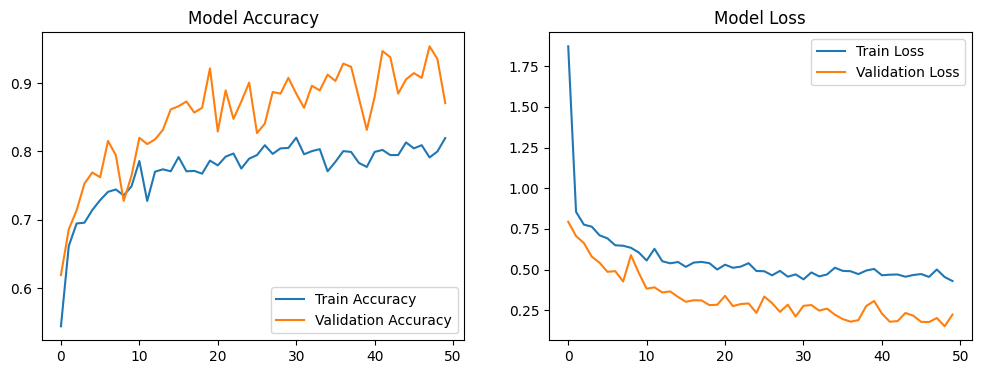

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.show()

In [ ]:
# to get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# to print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=CATEGORIES))

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step
Classification Report:
                     precision    recall  f1-score   support

           healthy       0.84      1.00      0.91       233
white scale/Stage1       1.00      0.40      0.57        70
white scale/Stage2       0.86      0.89      0.88        79
white scale/Stage3       1.00      0.90      0.95        51

          accuracy                           0.87       433
         macro avg       0.93      0.80      0.83       433
      weighted avg       0.89      0.87      0.85       433



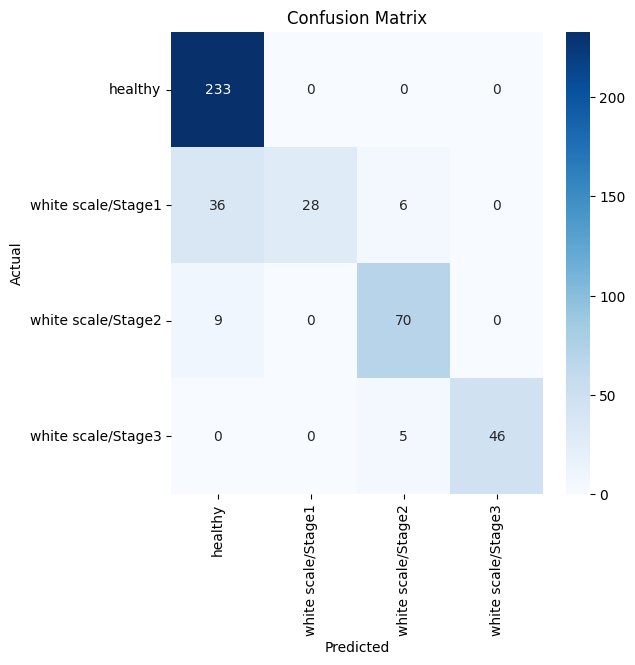

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/wsd_vgg16_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/wsd_vgg16_model.h5")

Testiing on new image


In [ ]:
def predict_wsd(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    predicted_class = CATEGORIES[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    return predicted_class, confidence


image_path = "/content/drive/MyDrive/WSD Dataset/test-image-2.jpeg"
pred_class, conf = predict_wsd(image_path, model)
print(f"Predicted Class: {pred_class} with {conf:.2f}% confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Predicted Class: healthy with 100.00% confidence


In [ ]:
image_path = "/content/drive/MyDrive/WSD Dataset/sample-image.jpg"
pred_class, conf = predict_wsd(image_path, model)
print(f"Predicted Class: {pred_class} with {conf:.2f}% confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted Class: healthy with 99.95% confidence


In [ ]:
image_path = "/content/drive/MyDrive/WSD Dataset/sample-image-2.jpg"
pred_class, conf = predict_wsd(image_path, model)
print(f"Predicted Class: {pred_class} with {conf:.2f}% confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predicted Class: white scale/Stage1 with 75.31% confidence


In [ ]:
image_path = "/content/drive/MyDrive/WSD Dataset/sample-image-3.jpg"
pred_class, conf = predict_wsd(image_path, model)
print(f"Predicted Class: {pred_class} with {conf:.2f}% confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted Class: white scale/Stage3 with 99.28% confidence


#optional GradCam


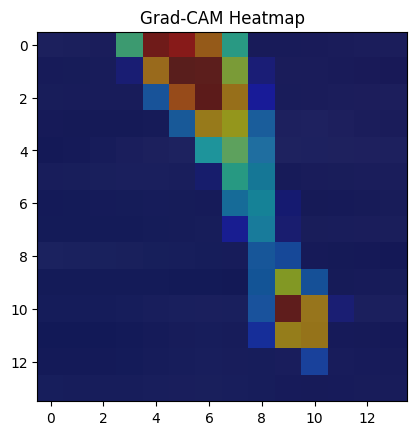

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def grad_cam(model, img_array, layer_name="block5_conv3"):
    """Generate Grad-CAM heatmap."""
    grad_model = tf.keras.models.Model(
        inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(np.expand_dims(img_array, axis=0))  # Ensured batch dimension
        class_idx = np.argmax(predictions[0])  # to get predicted class index
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0].numpy()  #to convert to numpy array before modifying

    for i in range(pooled_grads.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i].numpy()  #to convert pooled_grads[i] to numpy

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

# load & preprocess the image
image_path = "/content/drive/MyDrive/WSD Dataset/sample-image-3.jpg"
test_img = cv2.imread(image_path)
test_img = cv2.resize(test_img, (224, 224))  # resize to VGG16 input size
test_img = test_img / 255.0  # normalize

# generate grad-cam heatmap
heatmap = grad_cam(model, test_img)

# display the heatmap over the image
plt.imshow(test_img)
plt.imshow(heatmap, cmap="jet", alpha=0.5)  # Overlay heatmap on image
plt.title("Grad-CAM Heatmap")
plt.show()


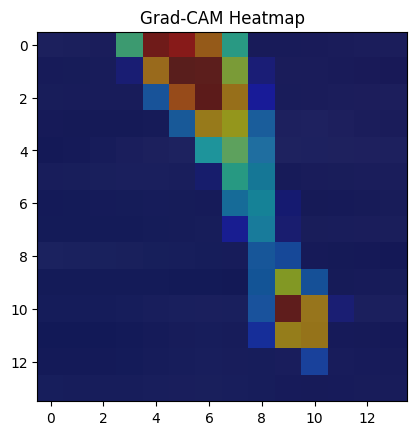

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def grad_cam(model, img_array, layer_name="block5_conv3"):
    """Generate Grad-CAM heatmap."""
    grad_model = tf.keras.models.Model(
        inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(np.expand_dims(img_array, axis=0))
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0].numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i].numpy()

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


image_path = "/content/drive/MyDrive/WSD Dataset/sample-image-3.jpg"
test_img = cv2.imread(image_path)
test_img = cv2.resize(test_img, (224, 224))
test_img = test_img / 255.0

heatmap = grad_cam(model, test_img)


plt.imshow(test_img)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.title("Grad-CAM Heatmap")
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2


def grad_cam(model, img_array, layer_name="block5_conv3"):
    """Generate Grad-CAM heatmap and overlay it on the image."""
    grad_model = tf.keras.models.Model(
        inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(np.expand_dims(img_array, axis=0))
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0].numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i].numpy()

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

Overlay Heatmap on Original Image


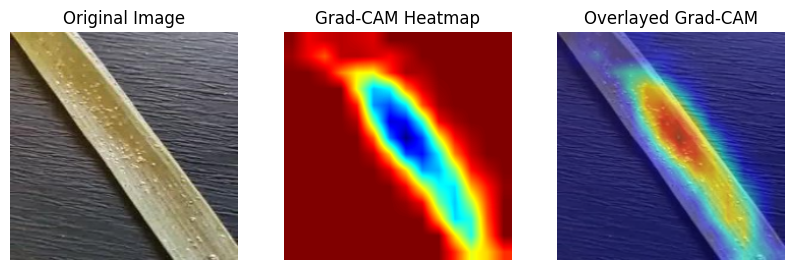

In [ ]:
def overlay_gradcam(image_path, model, layer_name="block5_conv3", alpha=0.5):
    """Load image, apply Grad-CAM, and overlay heatmap."""

    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0


    heatmap = grad_cam(model, img, layer_name)


    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


    original_img = cv2.imread(image_path)
    original_img = cv2.resize(original_img, (224, 224))


    overlay = cv2.addWeighted(original_img, 1 - alpha, heatmap, alpha, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Overlayed Grad-CAM")

    plt.show()


image_path = "/content/drive/MyDrive/WSD Dataset/sample-image-2.jpg"
overlay_gradcam(image_path, model)

In [ ]:
image_path = "/content/drive/MyDrive/WSD Dataset/test-image-4.jpg"
pred_class, conf = predict_wsd(image_path, model)
print(f"Predicted Class: {pred_class} with {conf:.2f}% confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
Predicted Class: healthy with 86.56% confidence
